### An example script to represent the 2-dimensional bin packing problem

In [26]:
#!pip3 install networkx matplotlib numpy h5py

In [27]:
#!pip3 install torch --index-url https://download.pytorch.org/whl/cu126
#!pip3 install torch_geometric

In [28]:
import torch
import matplotlib.pyplot as plt

from torch_geometric.loader import DataLoader
from matplotlib.patches import Rectangle

from model import GIN
from dataset import BinPacking2D, BinPackingGraph


In [29]:
n_epochs = 100
batch_size = 1
lr = 1e-4

in_channels=4
hidden_channels=16
out_channels=8

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

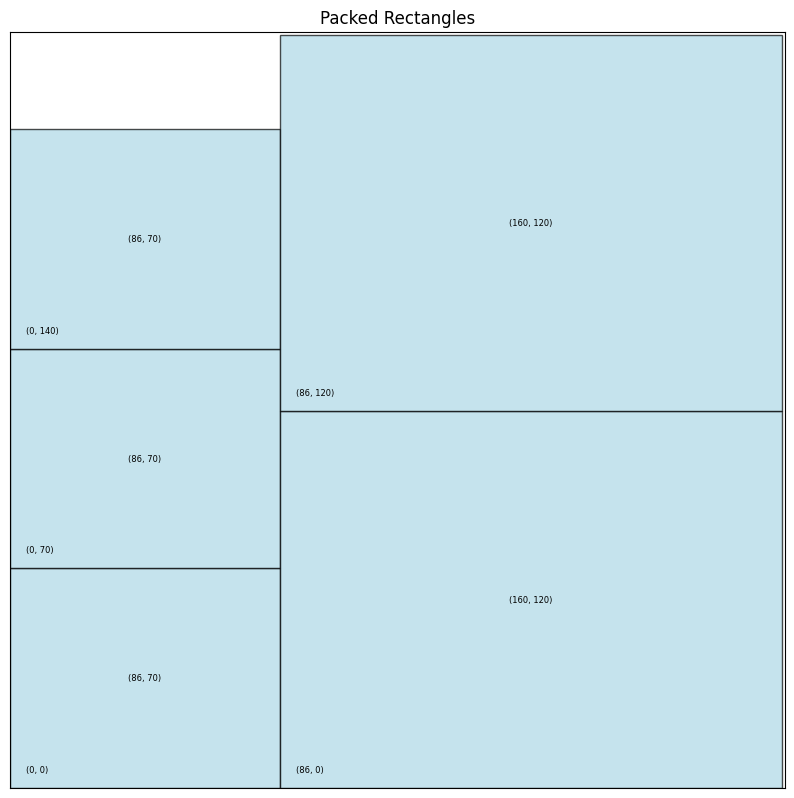

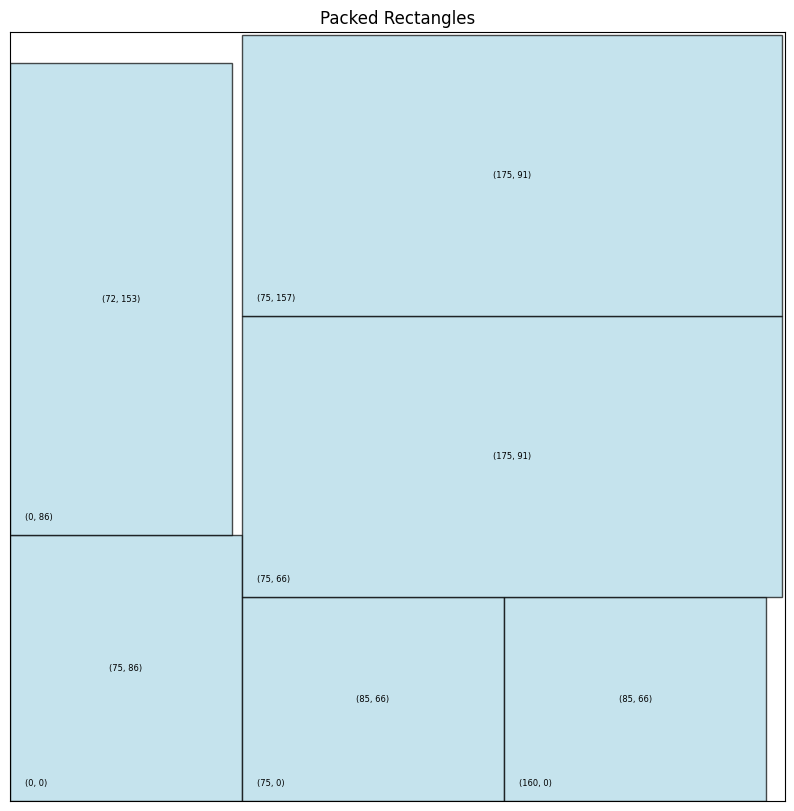

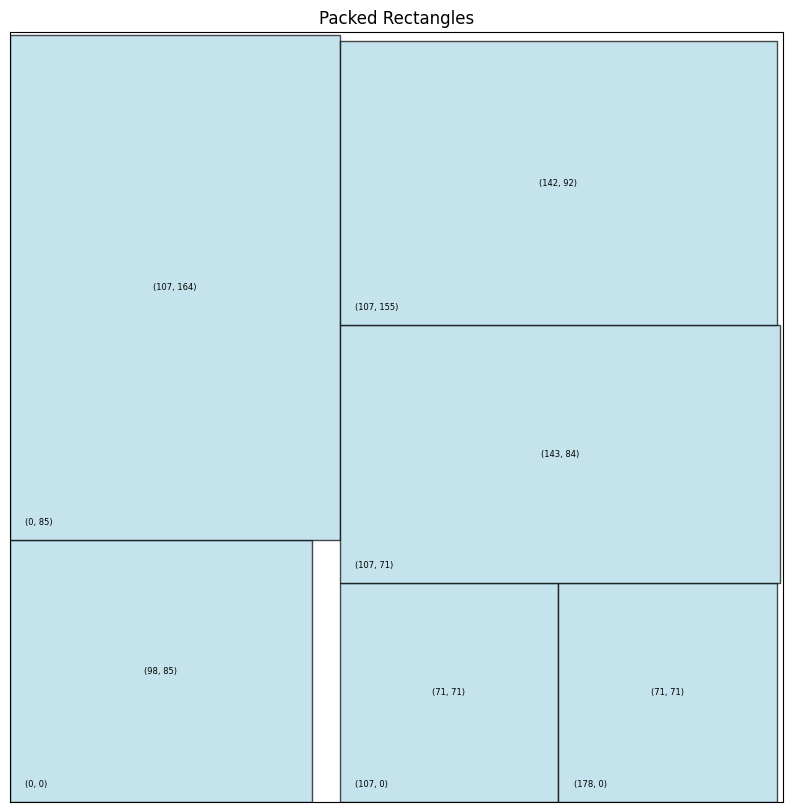

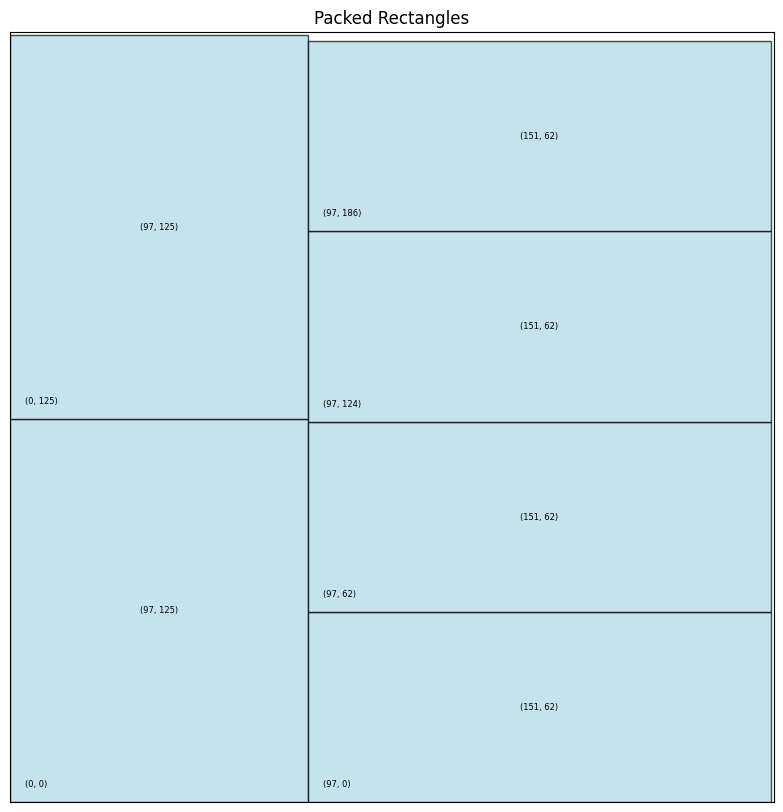

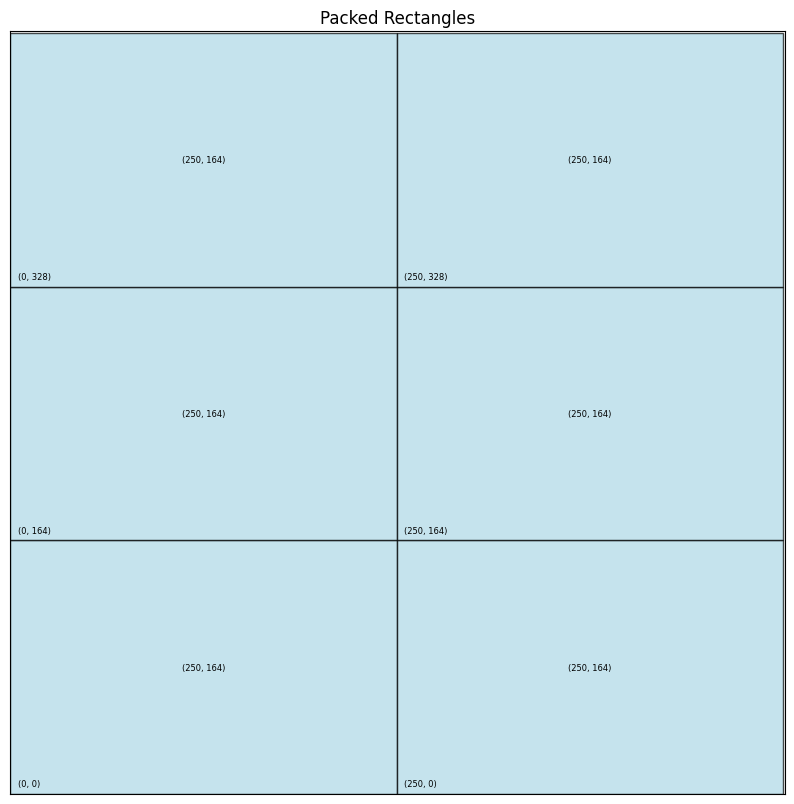

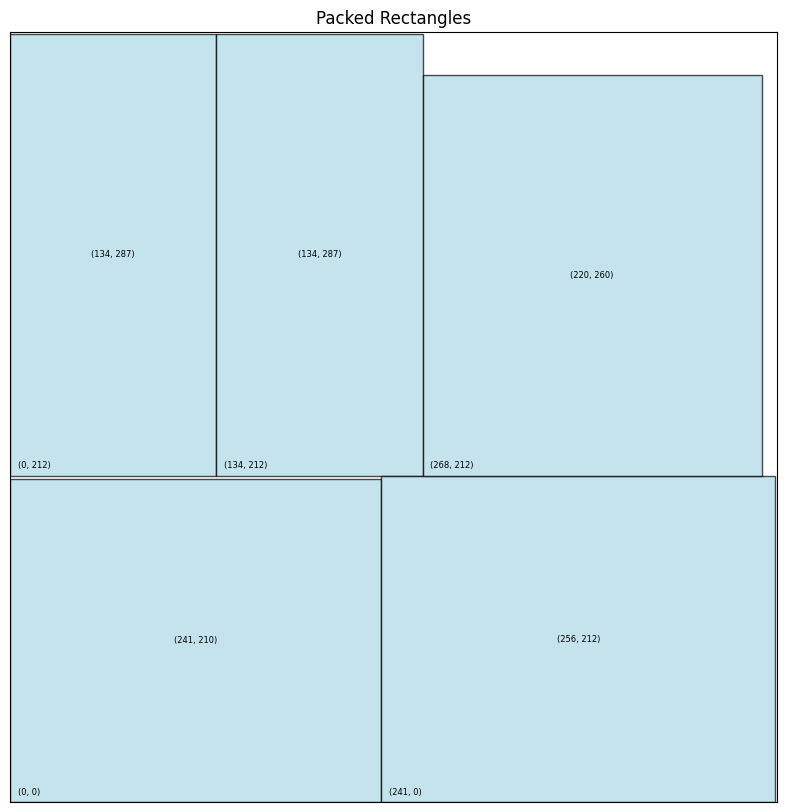

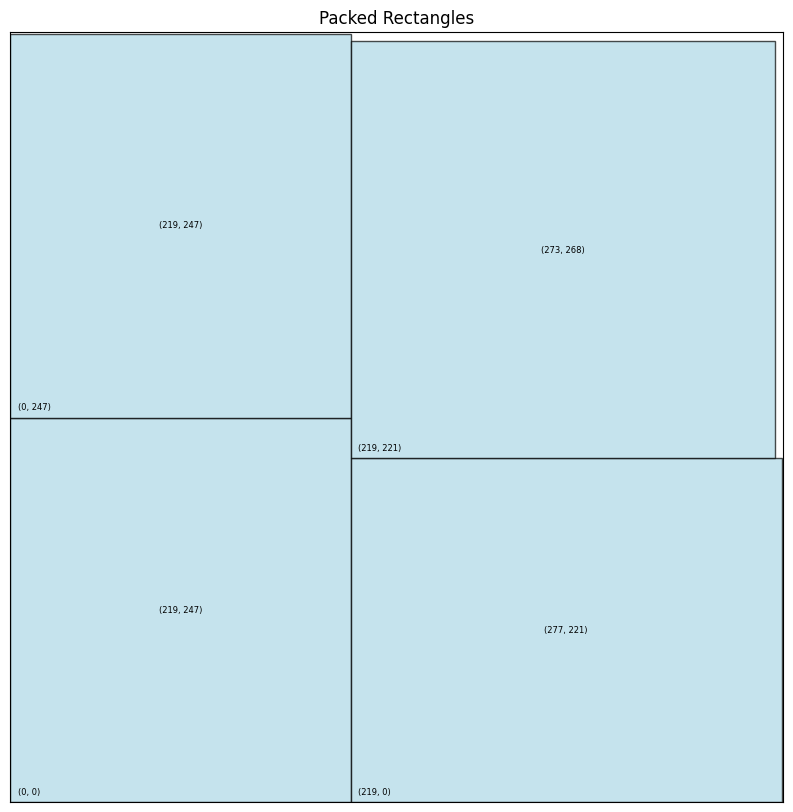

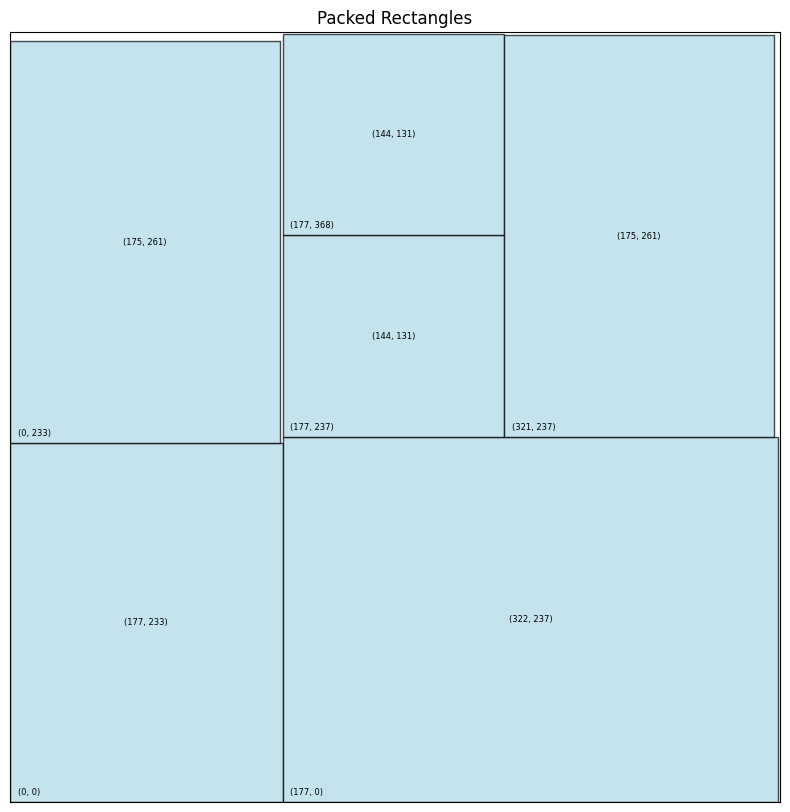

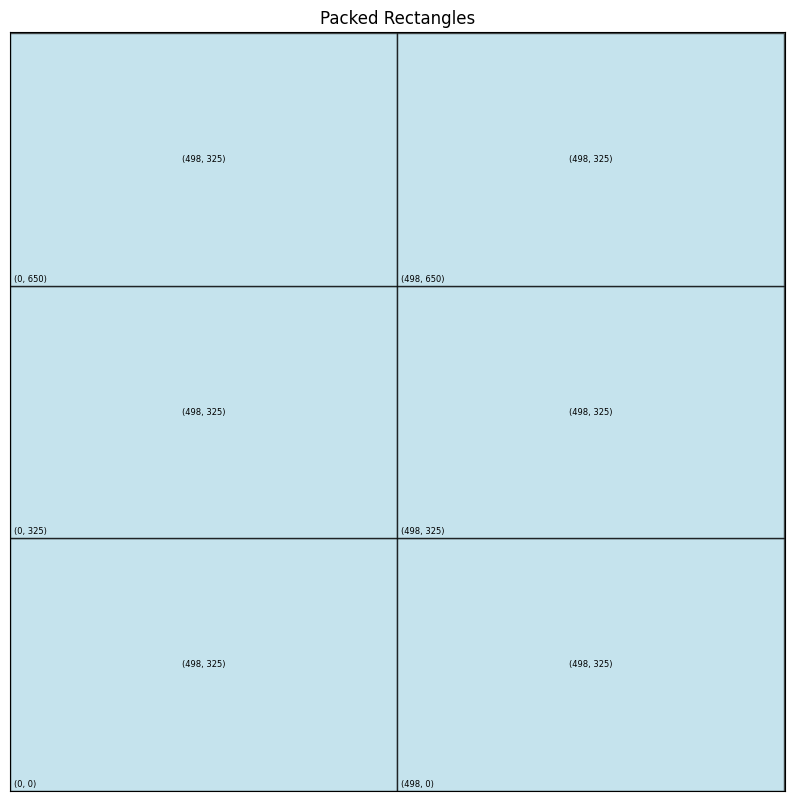

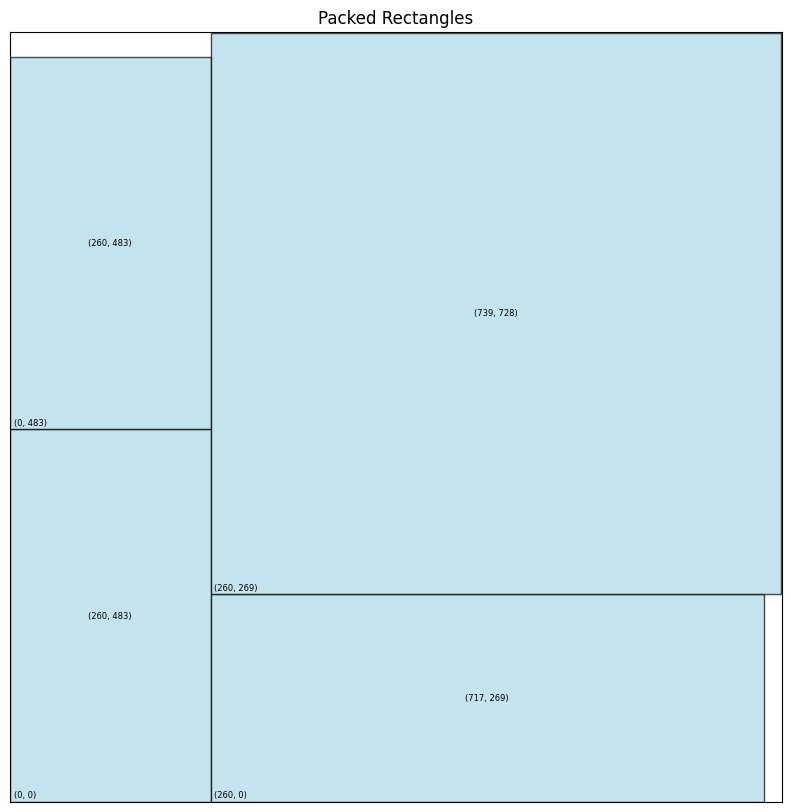

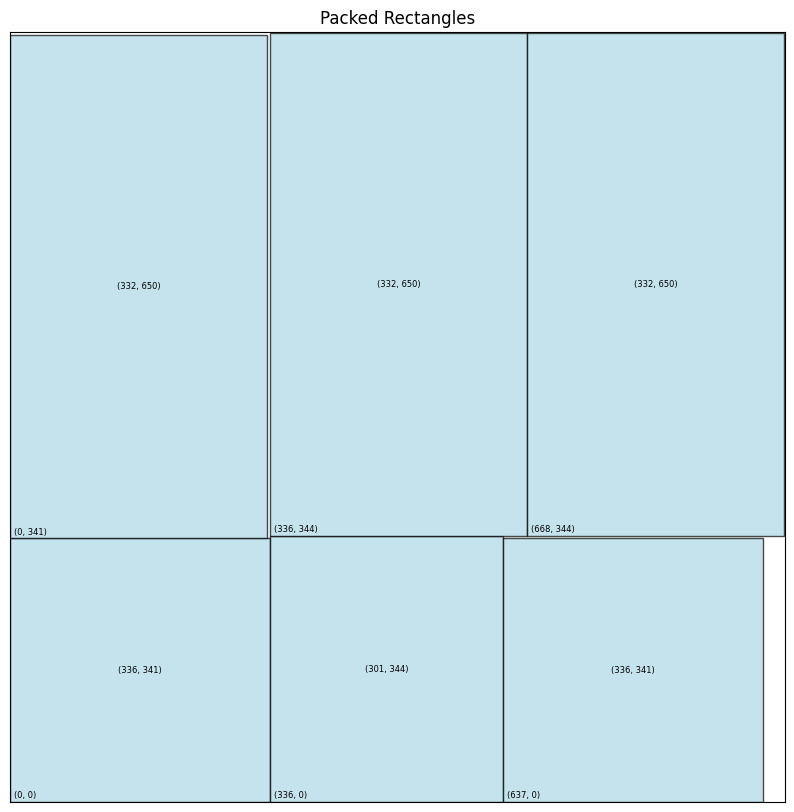

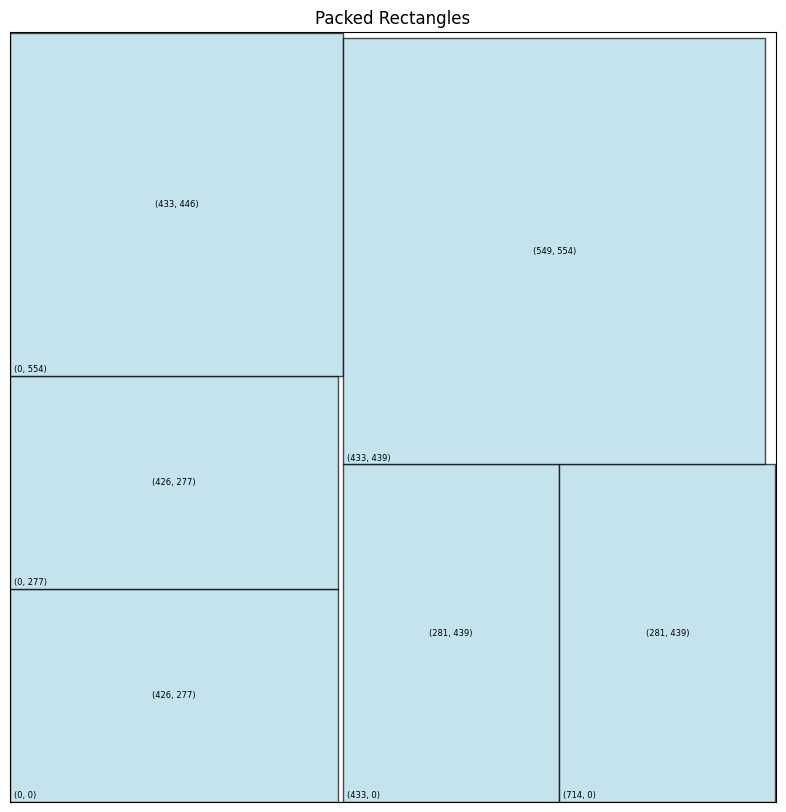

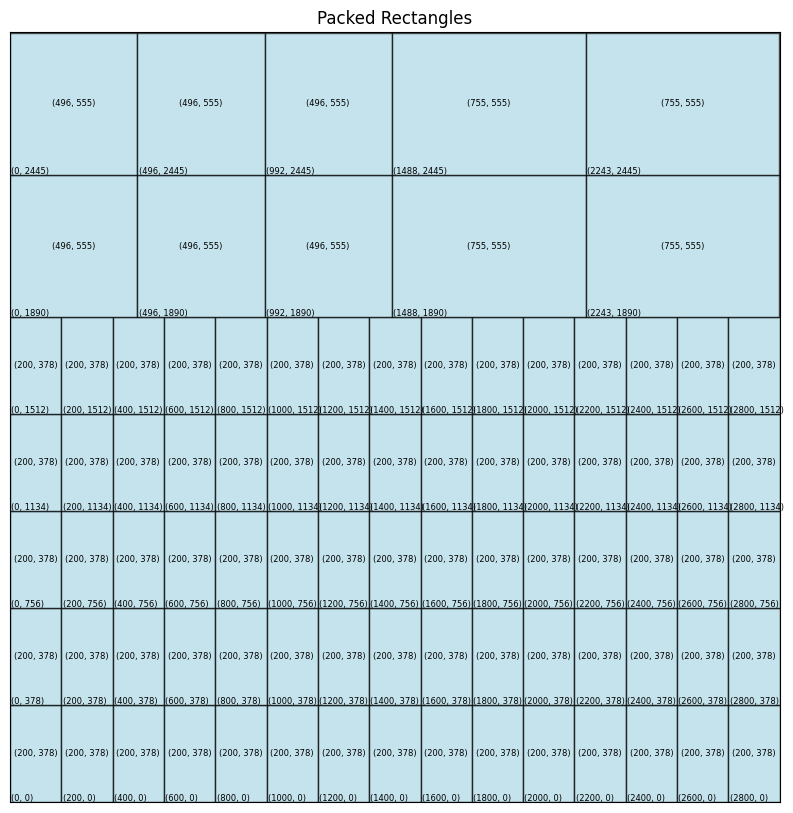

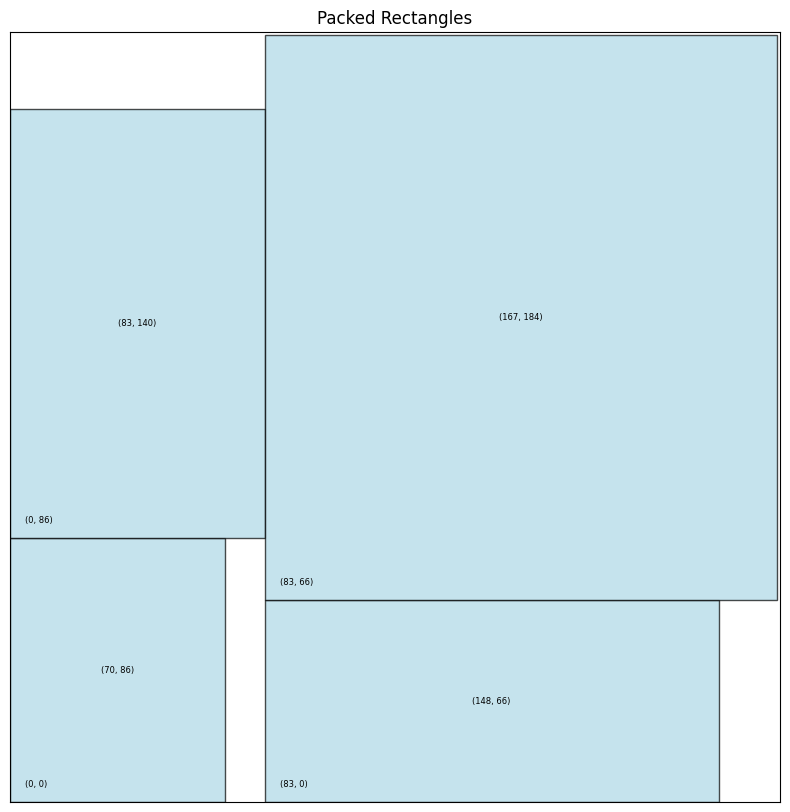

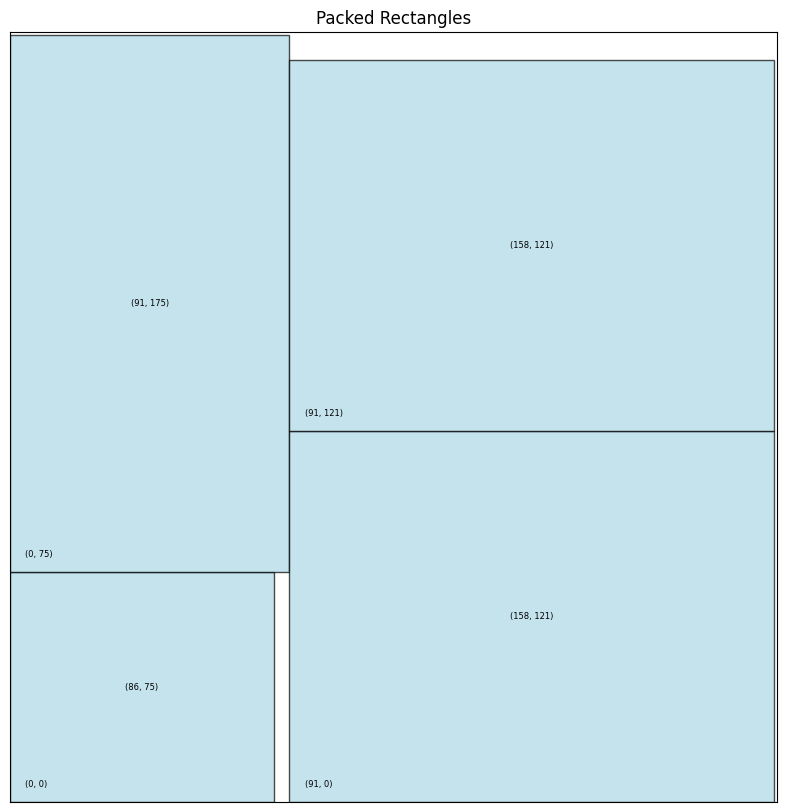

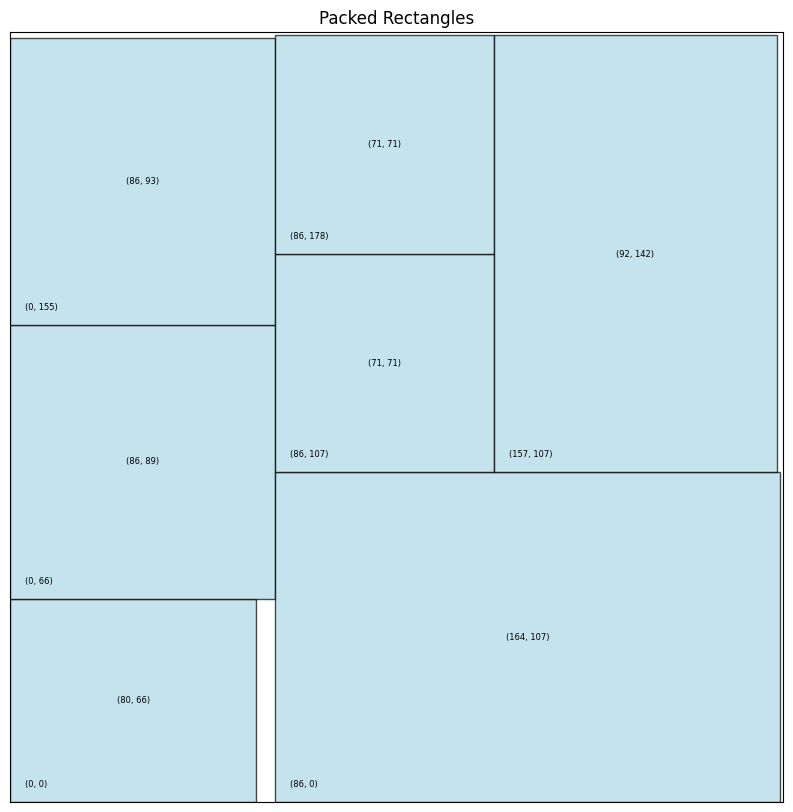

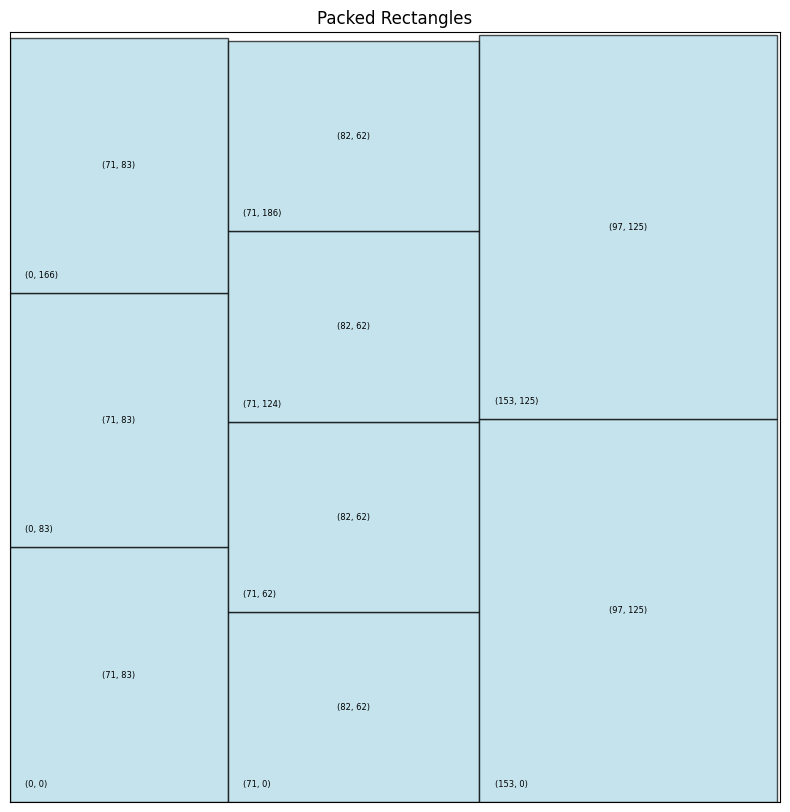

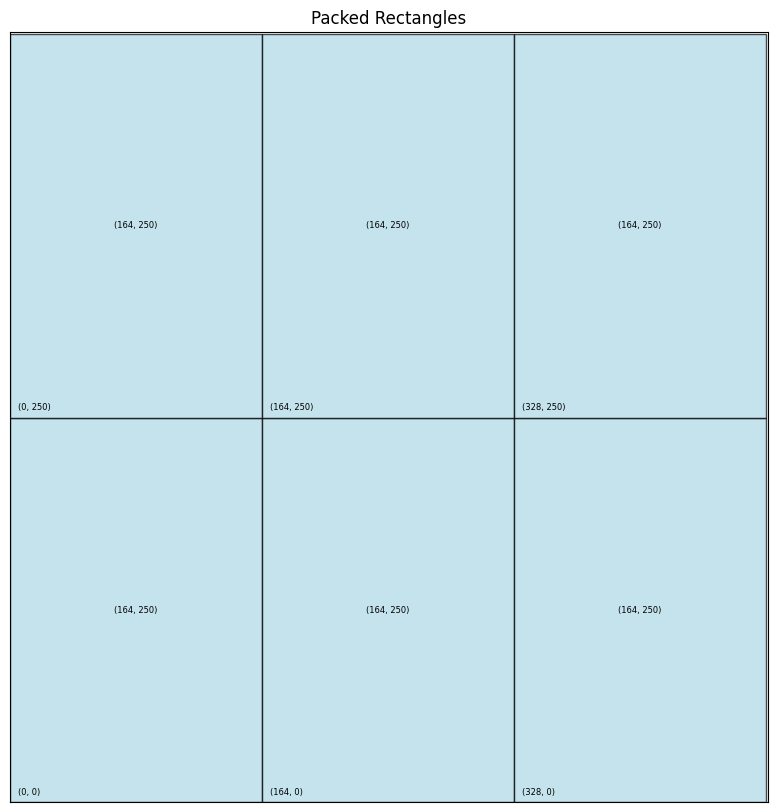

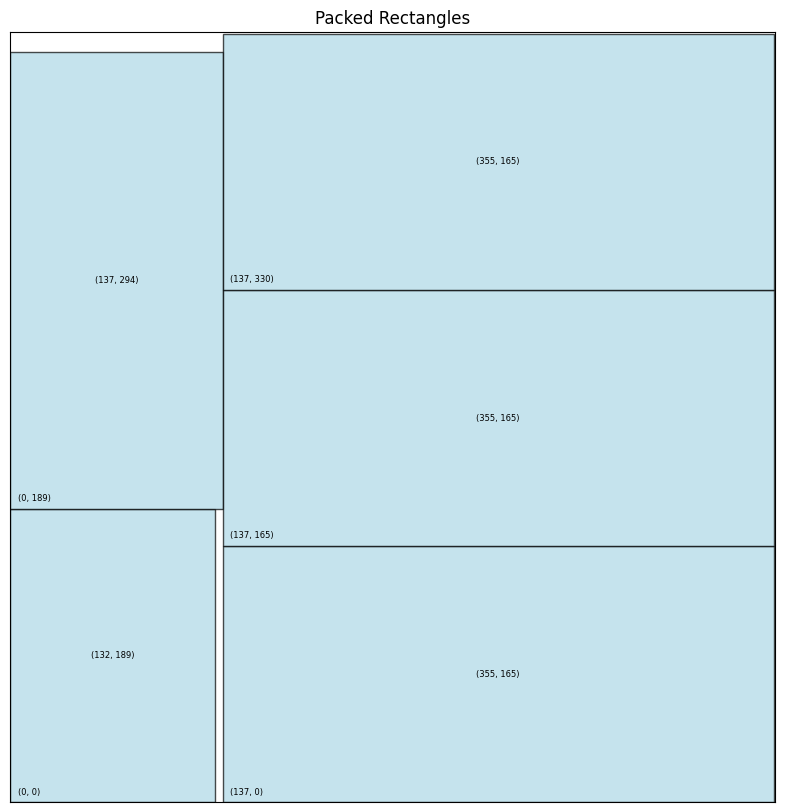

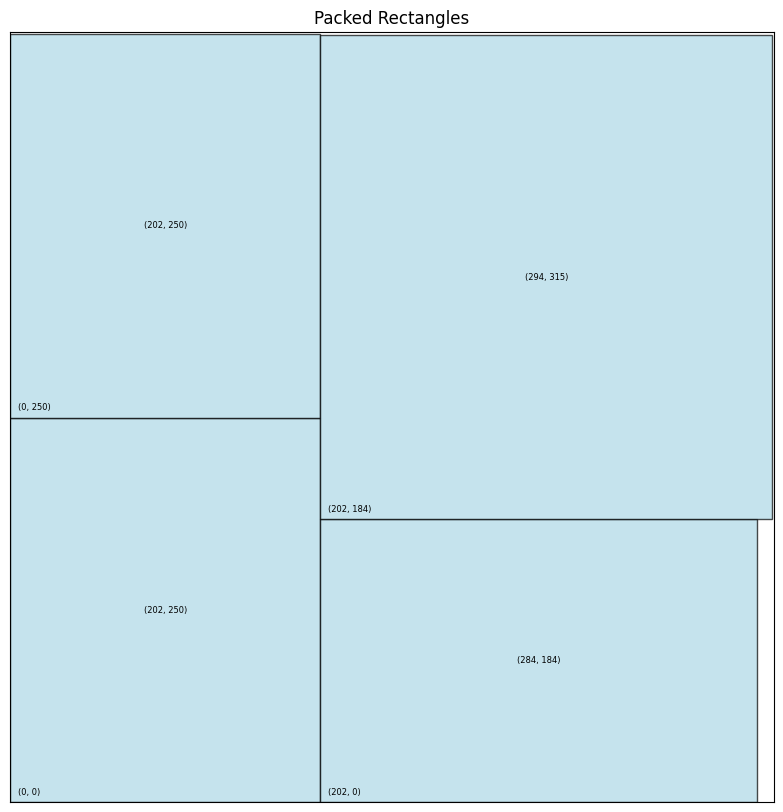

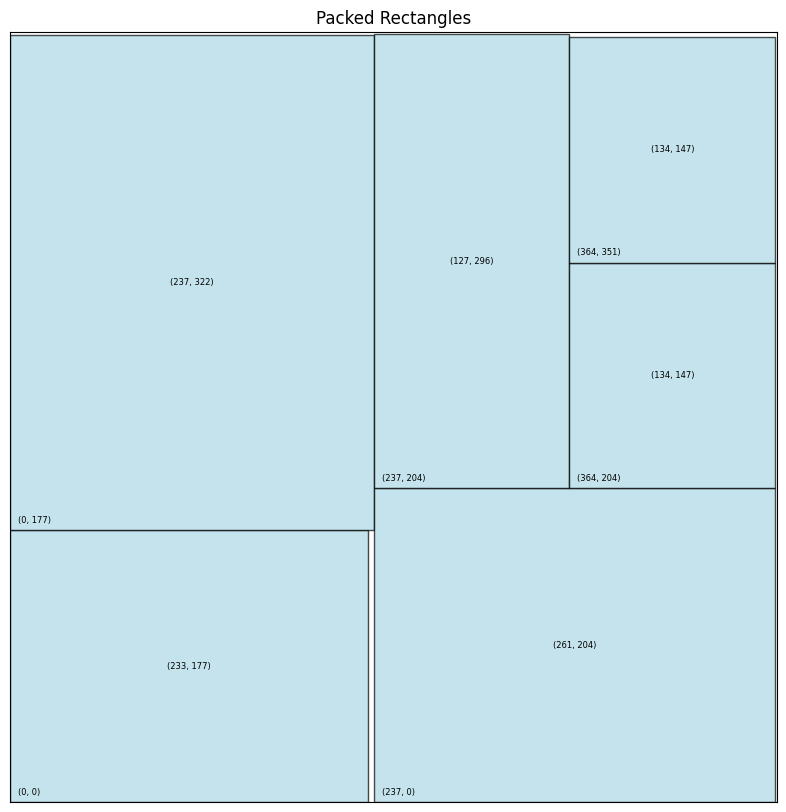

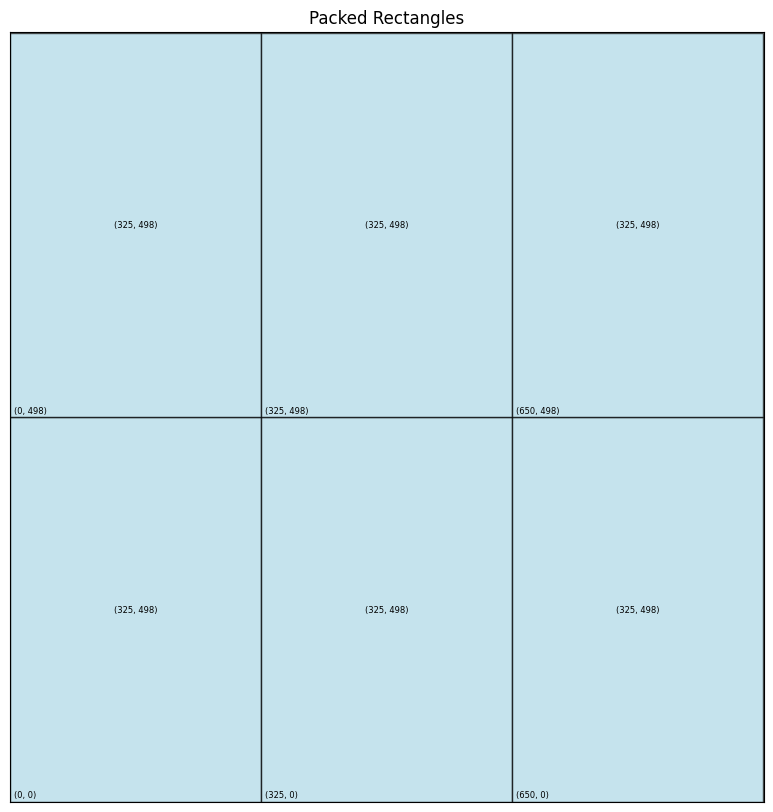

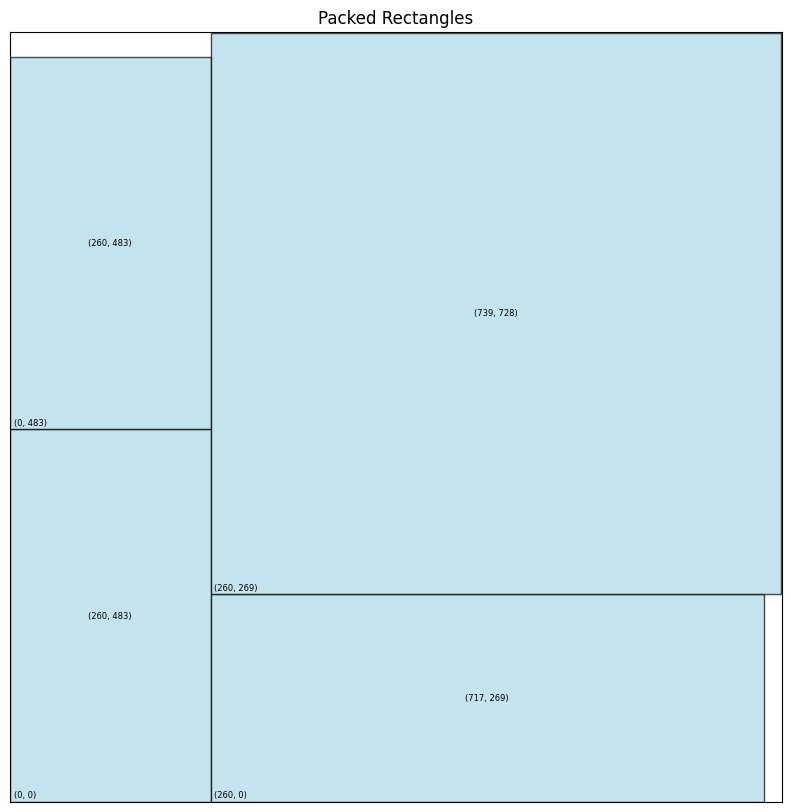

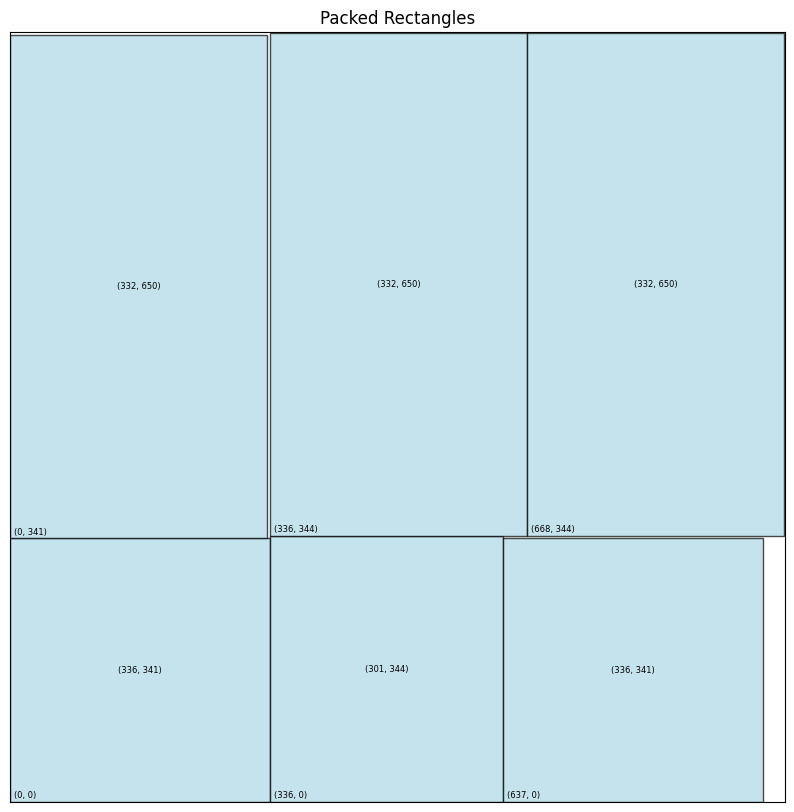

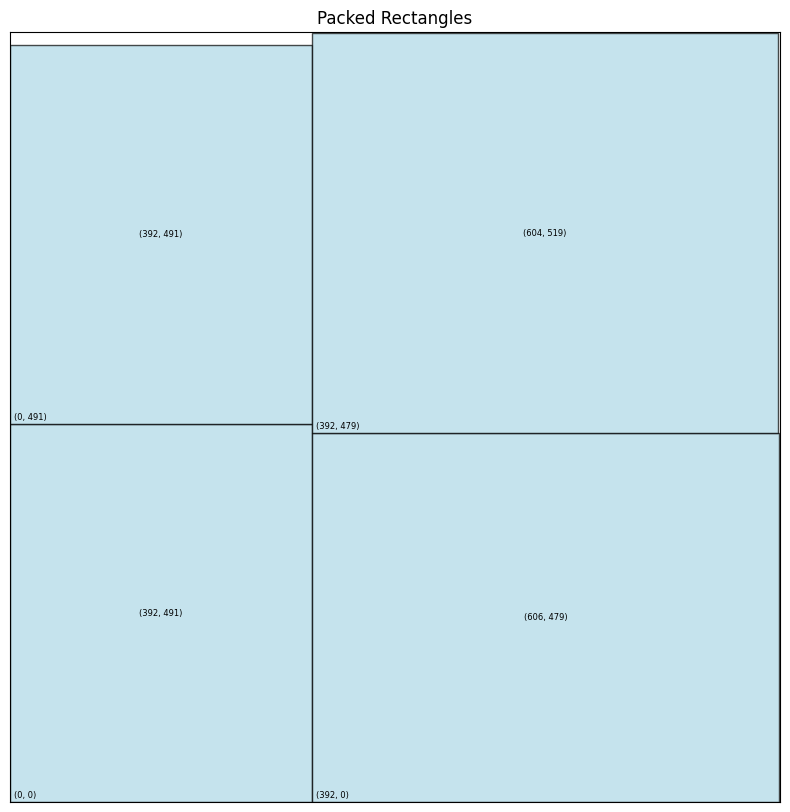

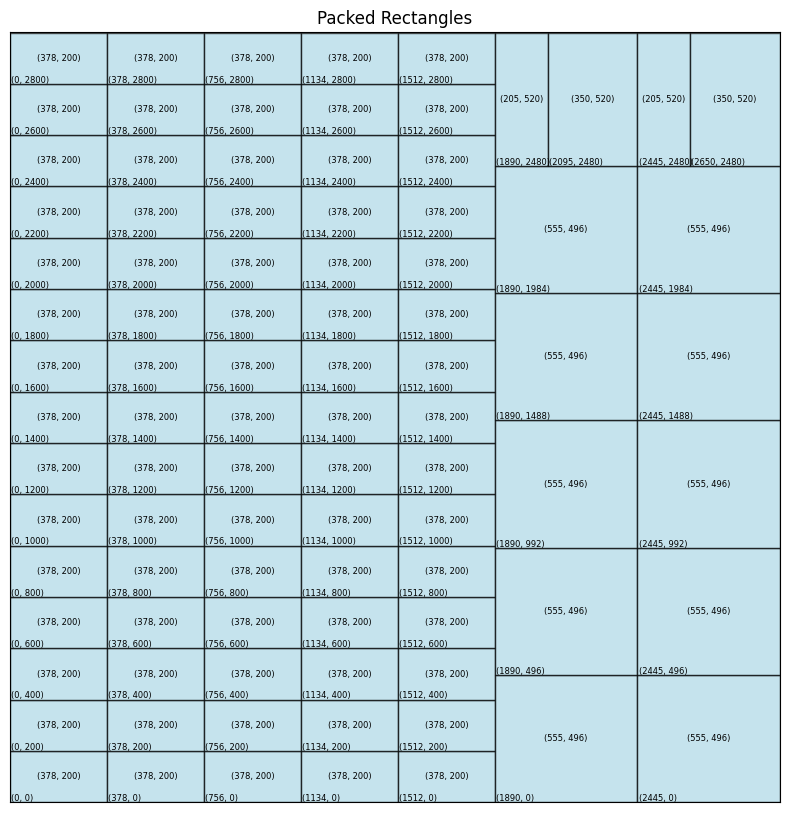

In [30]:
dataset = []
for i in range(1, 27, 1):
    with open(f"data/gcut/gcut{i}.txt", 'r') as f:
        set = []
        for line in f:
            values = []
            for value in line.split(" "):
                values.append(float(value))
            set.append(values)
        dataset.append(set)

for set in dataset:
    fig, ax = plt.subplots(figsize=(12, 6))
    x_size, y_size = set[0]
    for i, (w, h, x, y) in enumerate(set[1:]):
        # w /= x_size
        # h /= y_size
        # x /= x_size
        # y /= y_size
        rect = Rectangle((x, y), w, h, linewidth=1, edgecolor='black', facecolor='lightblue', alpha=0.7)
        ax.add_patch(rect)

        if x == int(x): x = int(x)
        if y == int(y): y = int(y)
        if w == int(w): w = int(w)
        if h == int(h): h = int(h)
        ax.text(x + w / 2, y + h / 2, f'({w}, {h})', fontsize=6, ha='center', va='center', color='black')
        ax.text(x + 5, y + 5, f'({x}, {y})', fontsize=6, color='black')

    ax.set_xlim(0, max(x + w for w, _, x, _ in set[1:]) + 1)
    ax.set_ylim(0, max(y + h for _, h, _, y in set[1:]) + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Packed Rectangles")
    ax.set_aspect('equal')

    fig.set_size_inches(10, 10)
    plt.show()
    plt.close()

In [31]:
items_list = [
    [(3, 2), (5, 3), (2, 4), (4, 2), (3, 3)],
    [(2, 2), (3, 4), (4, 2), (1, 5), (3, 3)],
    [(8, 7), (7, 2), (6, 6), (9, 1), (7, 4)],
    [(6, 1), (6, 4), (3, 5), (4, 8), (3, 7)],
    [(3, 2), (5, 3), (2, 4), (4, 2), (3, 3)]
]

container_width = 10

dataset = []
bps = []
for items in items_list:
    bp = BinPackingGraph(items, container_width)
    dataset.append(bp.nx_to_pyg())
    bps.append(bp)

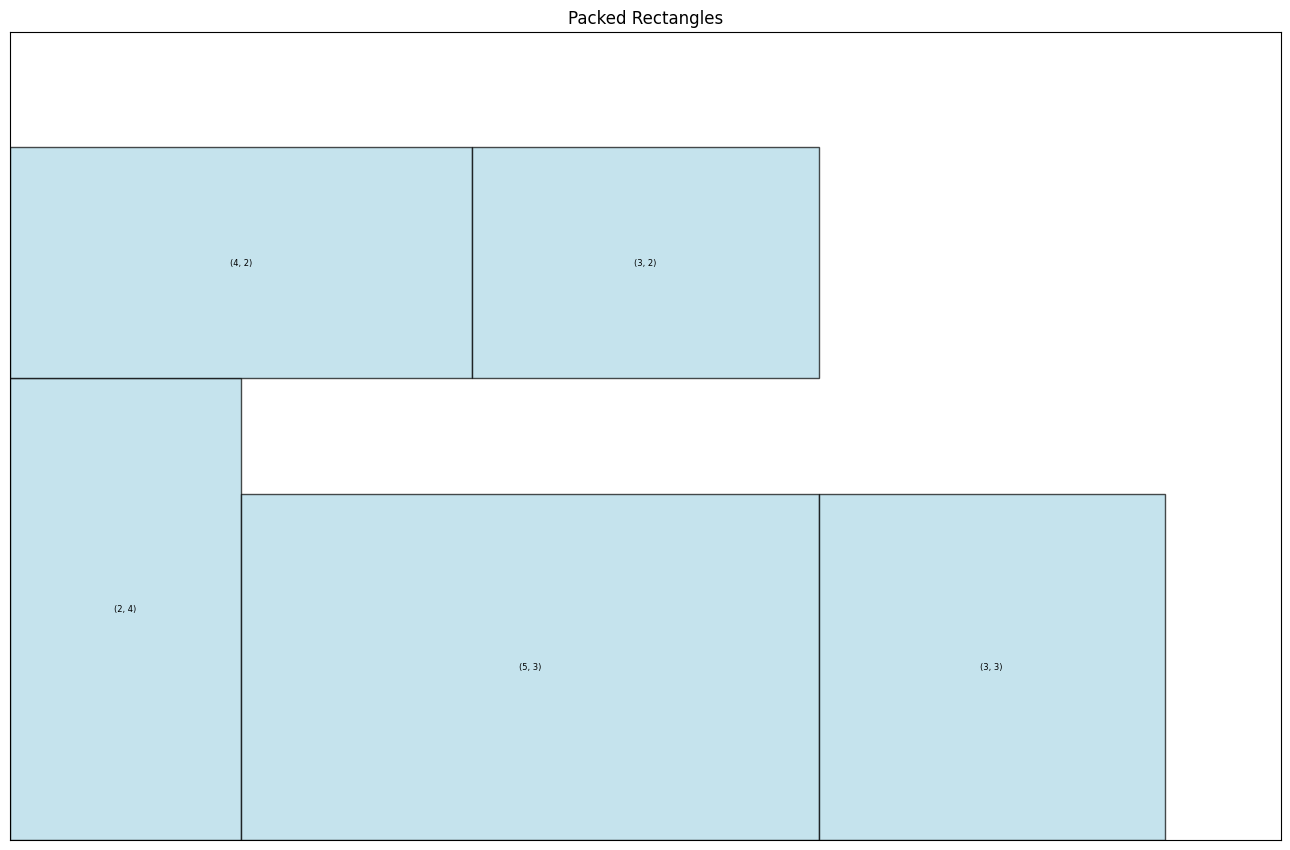

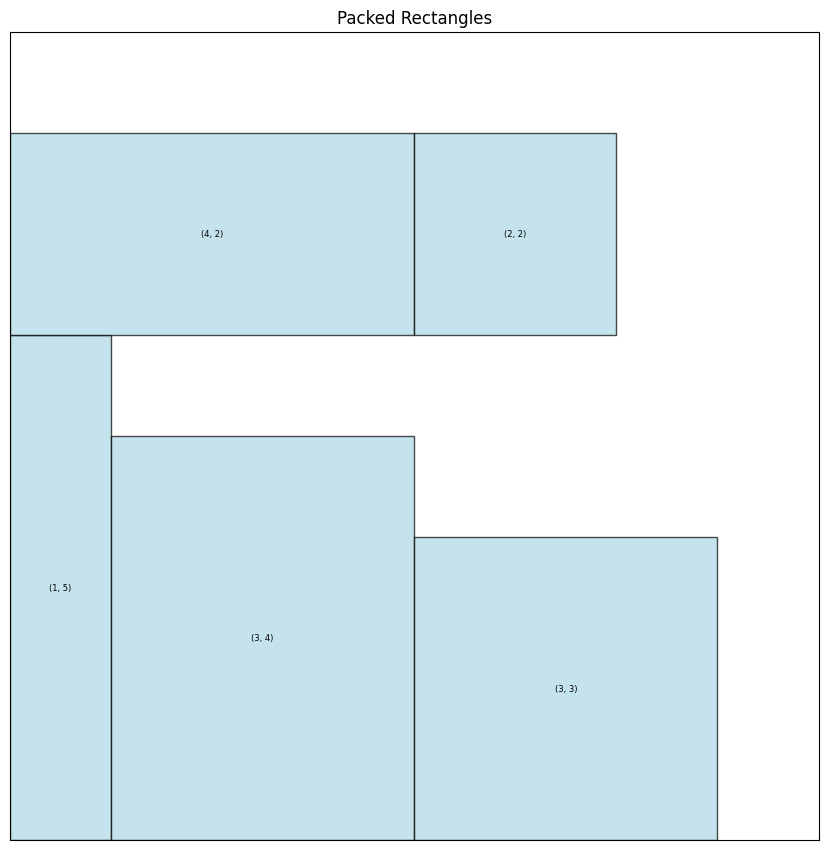

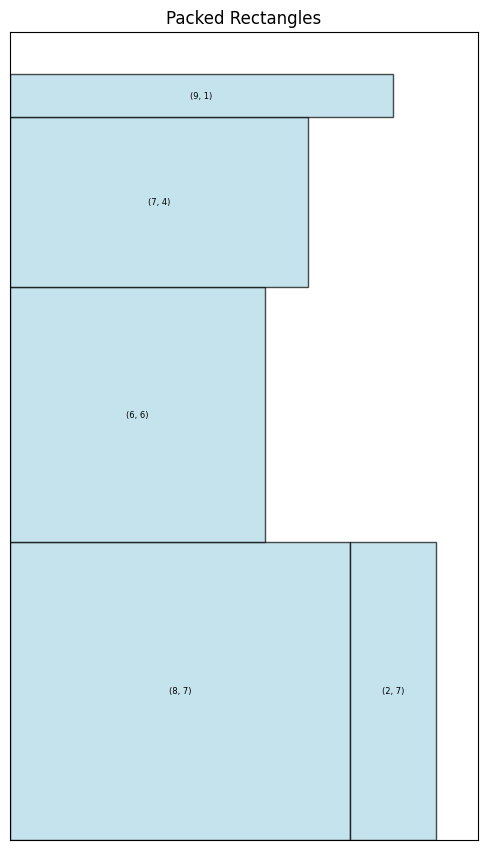

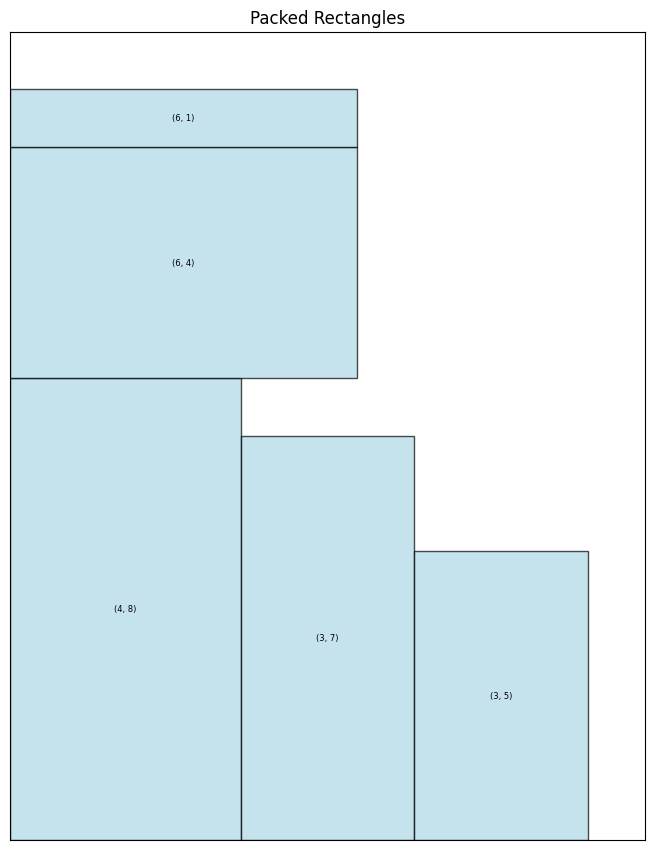

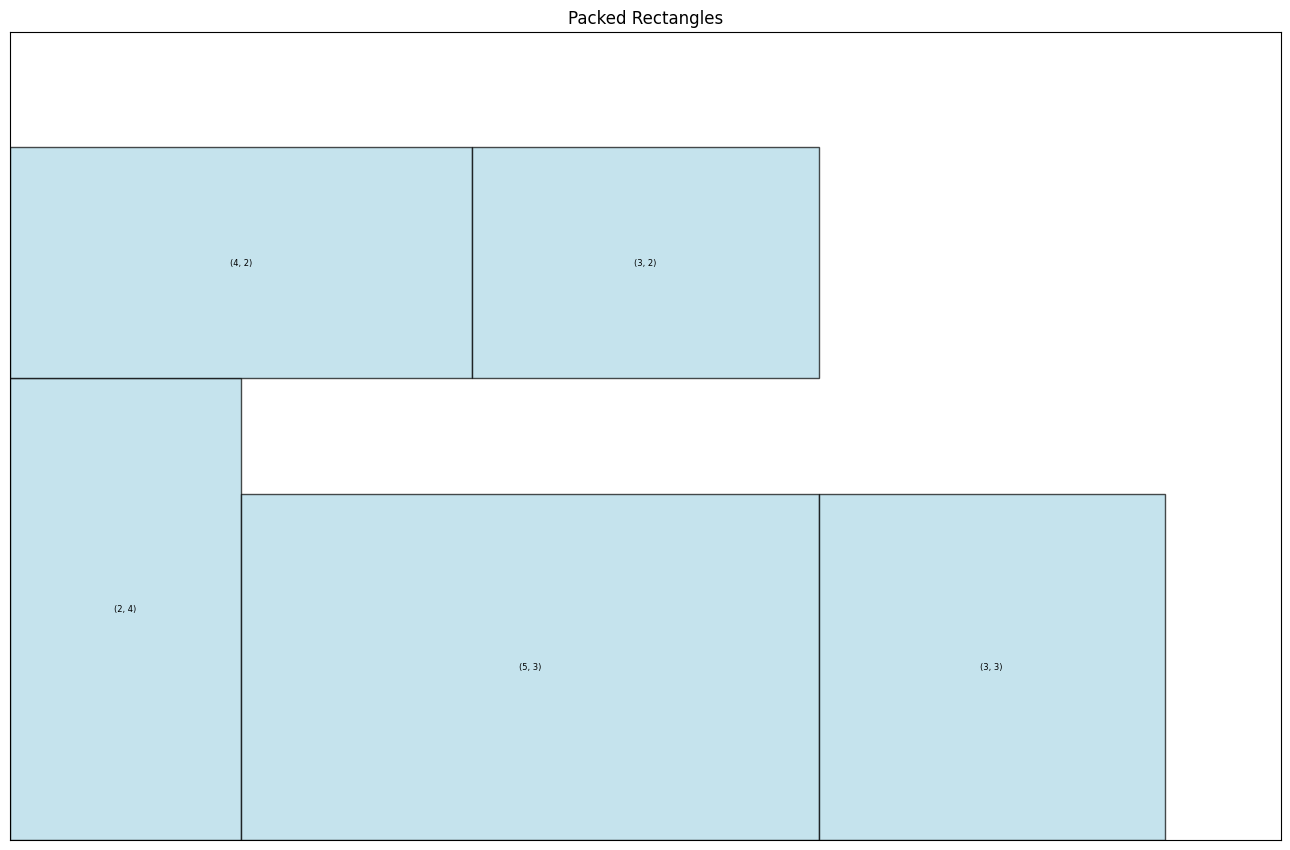

In [32]:
for bp in bps:
    bp.plot_packing()

<Figure size 640x480 with 0 Axes>

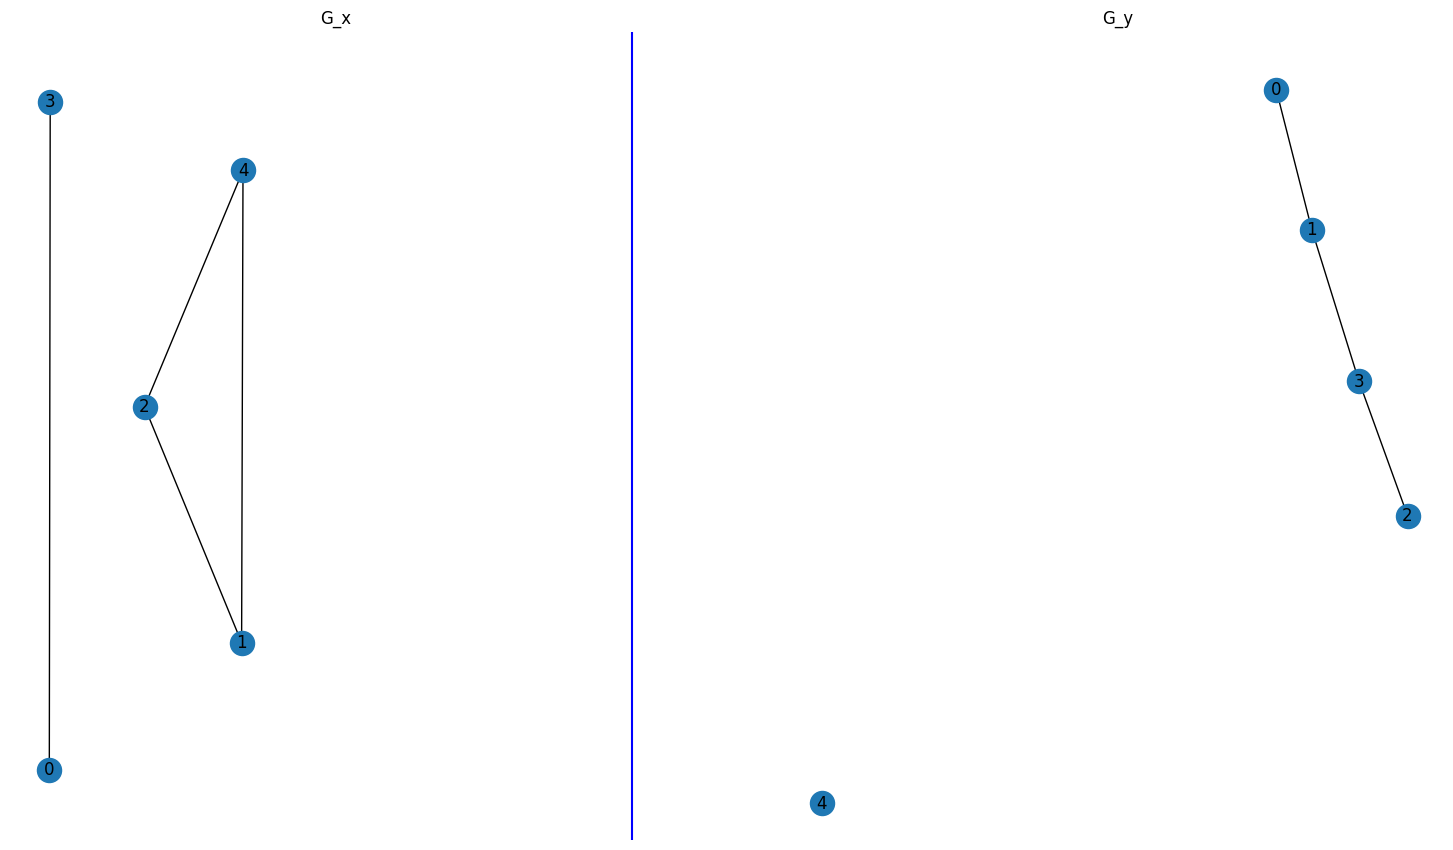

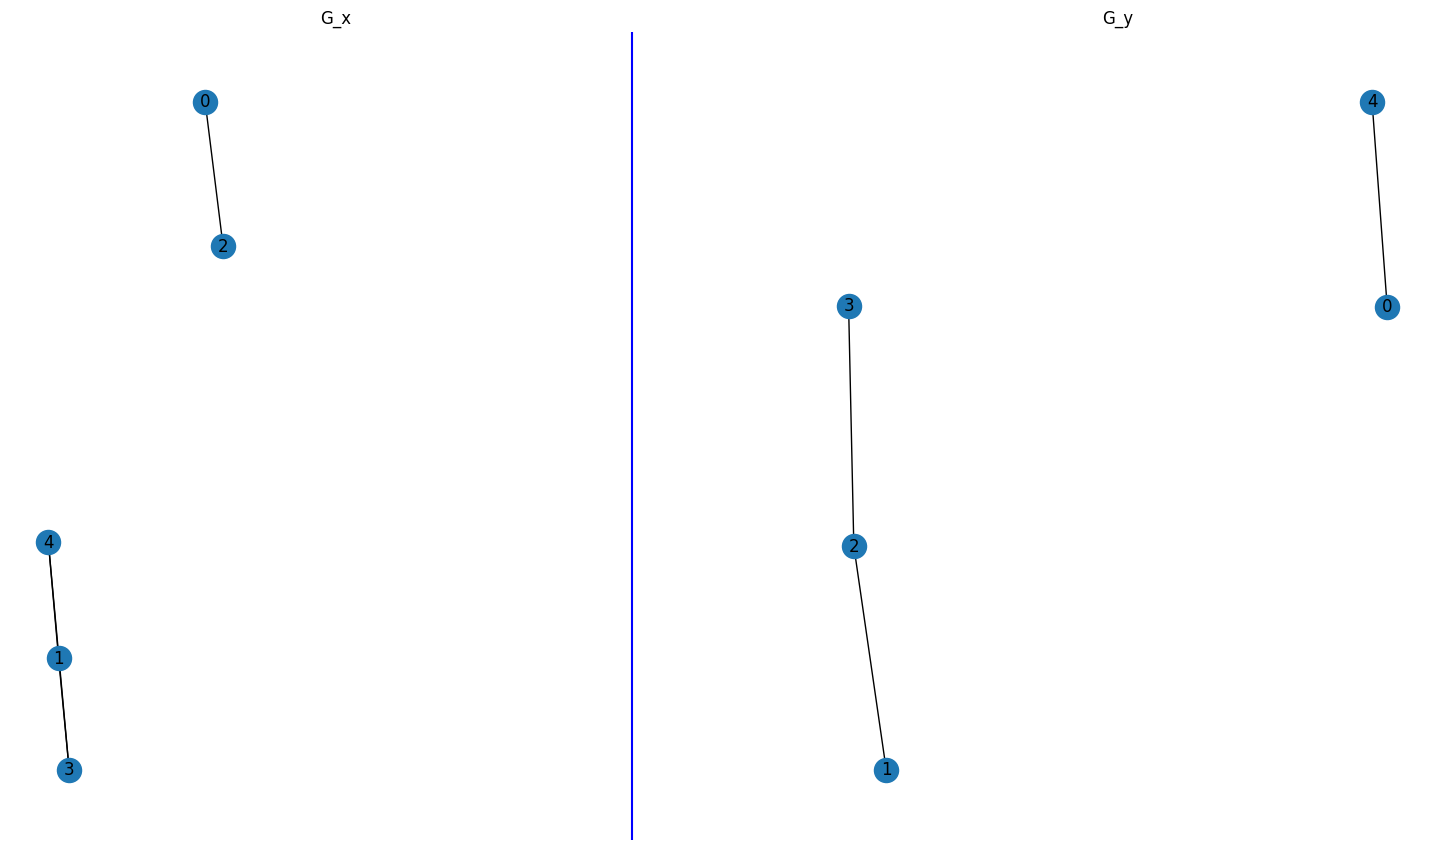

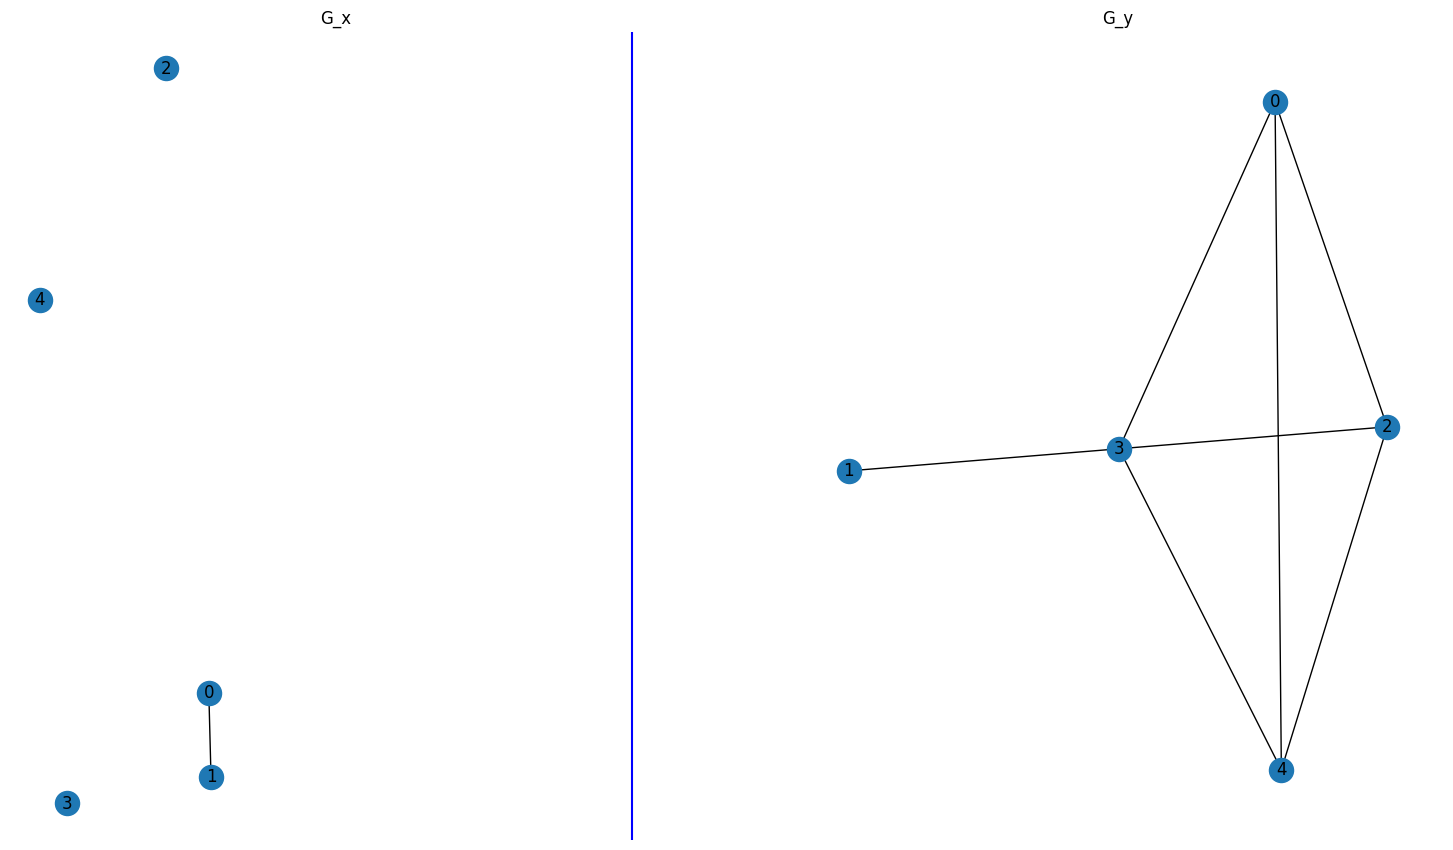

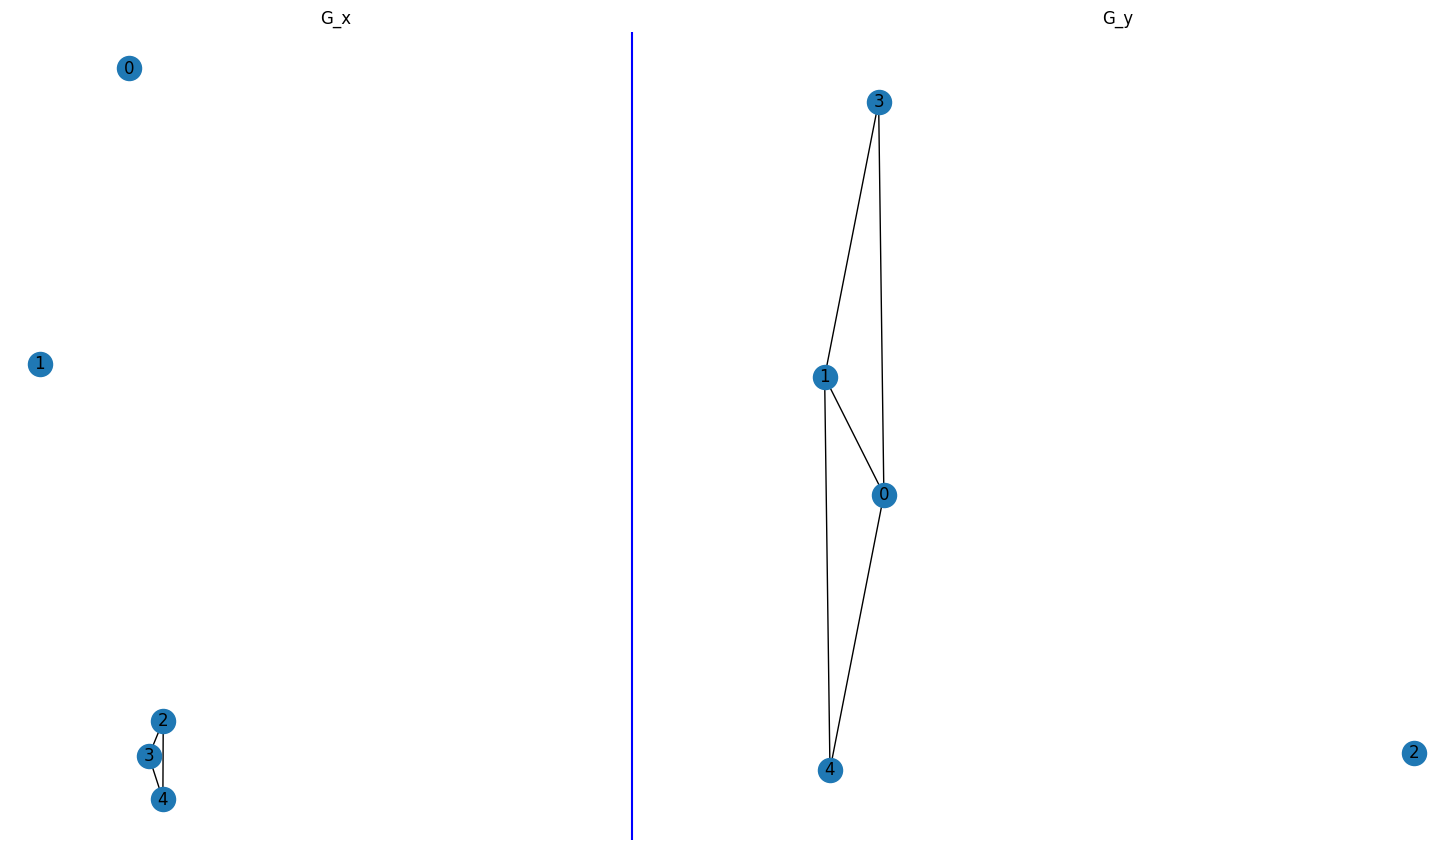

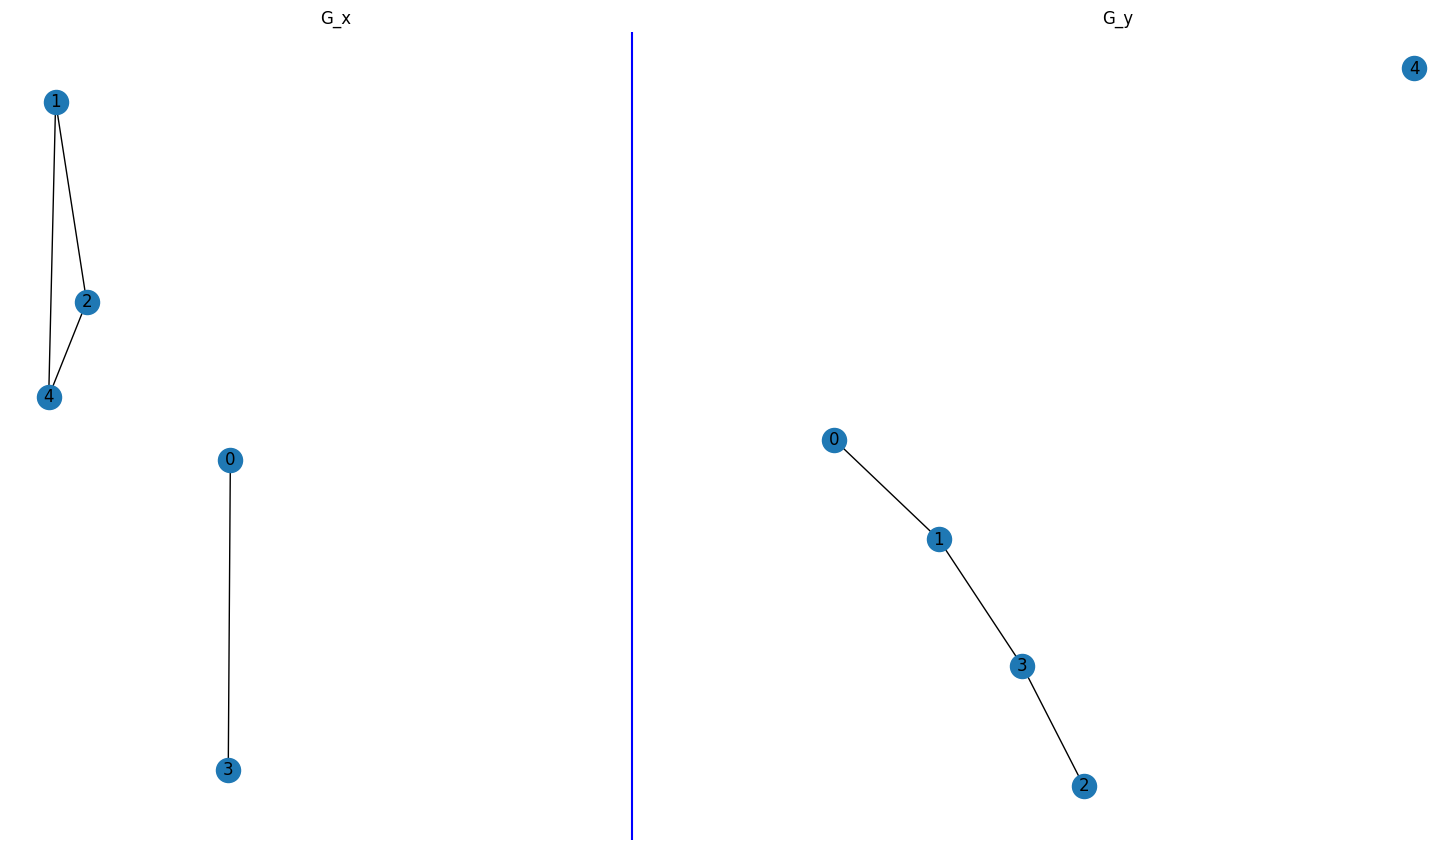

In [33]:
plt.tight_layout()

for bp in bps:
    bp.plot_graphs()

In [34]:
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = GIN(in_channels=4, hidden_channels=16, out_channels=8).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss()

def train(model, loader, optimizer, criterion, epochs=n_epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
        break
        #     loss = criterion(output, data.y)
        #     loss.backward()
        #     optimizer.step()
        #     total_loss += loss.item()
        # print(f"Epoch {epoch+1}, Loss: {total_loss / len(loader)}")

In [35]:
train(model, loader, optimizer, criterion, n_epochs)

torch.Size([5, 4]) torch.Size([2, 4]) torch.Size([2, 3])
torch.Size([5, 4]) torch.Size([2, 4]) torch.Size([2, 3])
torch.Size([5, 4]) torch.Size([2, 4]) torch.Size([2, 3])
torch.Size([5, 4]) torch.Size([2, 3]) torch.Size([2, 5])
torch.Size([5, 4]) torch.Size([2, 1]) torch.Size([2, 7])
